1. Process data into pickles with skip 40
2. Load this in to df dataloader
3. Train simple MLP map o -> a, observe it being okay
4. Get play subsequences, do goal conditioned BC, not just BC
5. LFP planner/encoder
6. Label a couple subsequences w/ language, and map that to the z space!

# Data Creation

In [ ]:
# # # Clean old data
# import glob
# import os
# demo_dir = os.getcwd() + '/' + "kitchen_demos_multitask/"
# old = glob.glob(demo_dir + "/**/*.pkl", recursive=True)
# movies = glob.glob(demo_dir + "/**/*.mp4", recursive=True)
# for i in old + movies:
#     print(i)
#     os.remove(i)

In [ ]:
# If Colab
COLAB = False
from google.colab import drive
drive.mount('/content/drive/')

if COLAB:
    class config(object):
        pass

    config = config()
    config.PYBULLET_PLAY = 'play_data/'
    config.DEVICE = 'TPU'

    %cd drive/My\ Drive

# Dataset

In [1]:
import glob

import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import random
import pickle
import os
import config
import data
import random

dataset_path  = config.ONEOBJ_PLAY # config.SCRIPTED_PLAY #config.RPL_PATH
keys = ['obs', 'acts', 'achieved_goals', 'joint_poses', 'target_poses']
physical_devices = tf.config.list_physical_devices(config.DEVICE)
if config.DEVICE is 'GPU':
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [2]:
# 
RELATIVE_JOINTS = True # use relative joiints instead of absolute angles

In [3]:
#dataset, cnt = data.create_single_dataset(dataset_path)


dataset, cnt = data.load_data(dataset_path, keys)

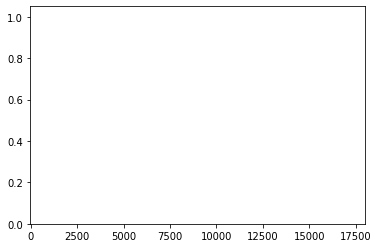

In [4]:
# Histogram of sequence lengths
plt.bar(cnt.keys(), cnt.values(), width=1)
plt.show()

In [5]:
total_frames = sum([x[0]*x[1] for x in cnt.items()])
print(f"We have {total_frames} frames of data, which is {total_frames/20/60} minutes.")

We have 57452 frames of data, which is 47.876666666666665 minutes.


In [6]:
class PyBulletRobotSeqDataset():
    def __init__(self, dataset, batch_size=64, seq_len=50, overlap=1.0, 
                 prefetch_size=None, train_test_split=0.8, seed=42, relative_joints=False):
        self.N_TRAJS = len(dataset)

        # Split into train and validation datasets
        # List of trajectory dicts
        if train_test_split == 'last': # just use the last set of demos as validation
            self._train_data = dataset[:-1] # raw data - private
            self._valid_data = dataset[-1:]
        else:
            self._train_data = dataset[:int(self.N_TRAJS*train_test_split)] # raw data - private
            self._valid_data = dataset[int(self.N_TRAJS*train_test_split):]
        self.train_data = []
        self.valid_data = []
        self.BATCH_SIZE = batch_size
        self.PREFETCH_SIZE = prefetch_size
        self.OVERLAP = overlap
        self.relative_joints = relative_joints

        self.MAX_SEQ_LEN = seq_len ## 40 for example
        self.MIN_SEQ_LEN = seq_len//2 # so like 20
        self.OBS_DIM = dataset[0]['obs'].shape[-1]
        if self.relative_joints:
            self.ACT_DIM = dataset[0]['target_poses'].shape[-1] + 1 # +1 for the gripper
        else:
            self.ACT_DIM = dataset[0]['acts'].shape[-1]
            
        self.GOAL_DIM = dataset[0]['achieved_goals'].shape[-1]

        self.random_obj = random.Random(seed)

    def create_goal(self, trajectory, ti, tf):
        return np.tile(trajectory['achieved_goals'][tf, :], (tf-ti,1))

    def traj_to_subtrajs(self, trajectory, idx):
        """
        Converts a T-length trajectory into M subtrajectories of length SEQ_LEN, pads time dim to SEQ_LEN
        """
        T = len(trajectory['obs'])
        subtrajs = []
        window_size = max(int(self.MAX_SEQ_LEN*self.OVERLAP),1)
        for ti in range(0,T,window_size):
            SEQ_LEN = np.random.randint(self.MIN_SEQ_LEN, self.MAX_SEQ_LEN) # random sequence lengths
            tf = ti + SEQ_LEN
            if T-1 < tf:
                break #trajectory would be cut off by the end of the data 
                
            pad_len = self.MAX_SEQ_LEN-(tf-ti)
            time_padding = ((0,pad_len),(0,0))
            #print(trajectory['obs'][ti:tf,:].shape, np.pad(trajectory['obs'][ti:tf,:], time_padding).shape)
            #print(np.pad(self.create_goal(trajectory, ti, tf), time_padding).shape)
            #print(np.pad(np.ones(tf-ti), time_padding[0]).shape)
            #print(np.pad(np.arange(ti, tf, 1), time_padding[0]).shape)
            
            if self.relative_joints:
                rel = trajectory['target_poses'][ti:tf] - trajectory['joint_poses'][ti:tf, :7]
                gripper = np.expand_dims(trajectory['acts'][ti:tf, -1], -1)
                action = np.pad(np.concatenate([rel, gripper], -1), time_padding)
            else:
                action = np.pad(trajectory['acts'][ti:tf], time_padding)
                
            
            subtraj_dict = {
                            'obs':np.pad(trajectory['obs'][ti:tf,:], time_padding)
                            , 'acts':action
                            , 'goals':np.pad(self.create_goal(trajectory, ti, tf), time_padding)
                            , 'loss_mask': np.pad(np.ones(tf-ti), time_padding[0])
                            , 'dataset_path':trajectory['reset_idx'] # which trajectory it is in the datadir
                            , 'tstep_idxs':np.pad(np.arange(ti, tf, 1), time_padding[0])   # which tstep it is in the trajectory
                            }
            subtrajs.append(subtraj_dict)
        return subtrajs

    def convert_dataset(self):
        """ Converts raw dataset to a shuffled subtraj dataset """
        for idx, train_sample in enumerate(self._train_data):
            self.train_data.extend(self.traj_to_subtrajs(train_sample, idx))

        for idx, valid_sample in enumerate(self._valid_data):
            self.valid_data.extend(self.traj_to_subtrajs(valid_sample, idx))

    def create_tf_ds(self, ds_type='train'):
        dataset = self.train_data if ds_type=='train' else self.valid_data
        def gen():
            for d in dataset:
                yield (d['obs'], d['acts'], d['goals'], d['loss_mask'], d['dataset_path'], d['tstep_idxs'])

        with tf.device('/cpu:0'):
            tf_ds =  tf.data.Dataset.from_generator(
                        gen
                        , output_types = (tf.float32, tf.float32, tf.float32, tf.float32, tf.int32, tf.int32)
                        , output_shapes = ((None,self.OBS_DIM), (None,self.ACT_DIM), (None,self.GOAL_DIM), (None), (None), (None)
            ))
            tf_ds = tf_ds.shuffle(len(dataset))
            tf_ds = tf_ds.batch(self.BATCH_SIZE, drop_remainder=True)
            tf_ds = tf_ds.prefetch(self.PREFETCH_SIZE)
        return tf_ds

In [7]:
#rsd = PyBulletRobotSeqDataset(dataset, batch_size=32, overlap=0.01, train_test_split='last', relative_joints=RELATIVE_JOINTS)
rsd = PyBulletRobotSeqDataset(dataset, batch_size=32, overlap=0.01, train_test_split=0.9, relative_joints=RELATIVE_JOINTS)

In [8]:
rsd.convert_dataset()

In [9]:
tf_train_data, tf_valid_data = rsd.create_tf_ds('train'), rsd.create_tf_ds('valid')

In [10]:
t_it = iter(tf_train_data)


In [11]:
o, a, g, m, pth, tsteps = t_it.next()
print(o.shape, a.shape, g.shape, m.shape)

(32, 50, 19) (32, 50, 8) (32, 50, 11) (32, 50)


# Model

In [12]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, ReLU, Input
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

In [13]:
class LSTM(tf.keras.Model):

    def __init__(self, act_dim, num_distribs = 3, layer_size = 2048, quantized = False):
        super(LSTM, self).__init__()
        self.num_distribs = num_distribs
        self.act_dim = act_dim
        self.quantized = quantized
        self.RNN1 = tf.keras.layers.LSTM(layer_size, return_sequences=True, return_state = True, name='LSTM_in_1')
        self.RNN2 = tf.keras.layers.LSTM(layer_size, return_sequences=True, return_state = True, name='LSTM_in_2')
        self.mu = tf.keras.layers.Dense(act_dim*num_distribs, activation=None, name='mu')
        self.scale = tf.keras.layers.Dense(act_dim*num_distribs, activation="softplus", name='sigma')
        self.weightings = tf.keras.layers.Dense(act_dim*num_distribs, activation="softplus", name='alpha')

    def call(self, inputs, goal, training=False, past_state = None):
        B = inputs.shape[0]
        inputs = tf.concat([inputs, goal], -1)
        state_out = None
        if len(inputs.shape) == 3:
            [x, _, _] = self.RNN1(inputs)
            [x, _, _] = self.RNN2(x)
        else:
            x = tf.expand_dims(inputs,1)
            [x, s1l1, s2l1] = self.RNN1(x, initial_state = past_state[0])
            [x, s1l2, s2l2] = self.RNN2(x, initial_state = past_state[1])
            state_out = [[s1l1, s2l1], [s1l2, s2l2]]
            

        mu, scale, weightings = self.mu(x), self.scale(x), self.weightings(x)
        mu, scale, weightings = tf.reshape(mu, (B, -1, self.act_dim, self.num_distribs)), tf.reshape(scale, (B, -1, self.act_dim, self.num_distribs)), tf.reshape(weightings, (B, -1, self.act_dim, self.num_distribs))
        
        if self.quantized:
            dist = tfd.TransformedDistribution(
                                    distribution= tfd.QuantizedDistribution(
                                            distribution=tfd.TransformedDistribution(
                                                distribution=tfd.Logistic(loc=mu, scale=scale),
                                            bijector=tfb.AffineScalar(shift=-0.5)),
                                        low=-128,
                                        high=128), 
                                    bijector=tfb.AffineScalar(scale=1/512))

        else:
            dist = tfd.Logistic(loc=mu, scale=scale)
        
        mixture = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(
                          probs=weightings),components_distribution=dist)
        if state_out is None:
            return mixture
        else:
            return mixture, state_out

# Training Loop

In [14]:
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import Progbar

import time

# Whether to use probabilstic MLP or not
PROBS = True
# Whether to use LSTM models, as probabilistic models are better they will all be PROB true
SEQ = True


In [15]:

@tf.function
def step(obs,acts,goals, model, mask=None):
    
    mixture = model(obs,goals)
    # make it the same dimension as the mask if we have one
    
    vals = tf.reduce_mean(mixture.log_prob(acts), -1)
    
    loss = -tf.reduce_mean(vals * mask)
    
    # also compare MSE between est and true actions
    pred = mixture.sample() # B,T,D
    sampled_l = abs((acts-pred))
    sampled_l = tf.reduce_mean(sampled_l, [0,1])
    return loss, sampled_l

@tf.function
def train_step(obs,acts, goals, model, optimizer, mask = None):
    with tf.GradientTape() as tape:
        loss, sampled_l = step(obs,acts, goals, model, mask)
        
    variables = model.trainable_variables
    
    gradients = tape.gradient(loss, variables)
    
    optimizer.apply_gradients(zip(gradients, variables))
    return loss, sampled_l
        

In [16]:
import tensorflow_addons as tfa
# Instantiate an optimizer to train the model. Use same LR as LFP paper. 
optimizer = tfa.optimizers.AdamW(learning_rate=3e-4, weight_decay=1e-4) #Adam(learning_rate=3e-4)
# Instantiate a loss function.

model = LSTM(act_dim = rsd.ACT_DIM)


# Prepare the metrics.
# train_acc_metric = Accuracy()

In [17]:

steps = []
losses = []
valid_losses = []
valid_steps = []
sampled_ls = []
valid_sampled_ls = []
n_steps = 300000
progbar = Progbar(n_steps, verbose=1, interval=0.5)
data_time = []
train_time = []
best_valid_loss = np.float('inf')

In [23]:

# Repeat datasets indefinitely
valid_data_iter = iter(tf_valid_data.repeat(-1))
#train_data_iter = iter(tf_train_data.repeat(-1))

# TODO RAY async trajectories in background so we can watch it's learning progress.
# We want to reshuffle the datset each time

train_data_iter = iter(rsd.create_tf_ds('train'))

t0  = time.time()
for t in range(len(steps),n_steps):
    t1= time.time()
    try:
        train_obs,train_acts,train_goals, train_mask, _,_  = train_data_iter.next()
    except:
        print('Regenning Datset')
        train_data_iter= iter(rsd.create_tf_ds('train'))
        train_obs,train_acts,train_goals, train_mask, _,_  = train_data_iter.next()
        
    #train_obs,train_acts,train_goals, train_mask = sample_sequence_batch(train_data)
    t2 = time.time()
    loss, sampled_l = train_step(train_obs,train_acts,train_goals, model, optimizer, train_mask)
    t3 = time.time()
    data_time.append(t2-t1)
    train_time.append(t3-t2)
    steps.append(t)
    losses.append(loss)
    sampled_ls.append(sampled_l.numpy())
    if t % 100 == 0:
        valid_steps.append(t)
        valid_obs, valid_acts, valid_goals, valid_mask,_,_ = valid_data_iter.next()
        #valid_obs, valid_acts, valid_goals, valid_mask = sample_sequence_batch(valid_data)
        valid_loss, valid_sampled_l = step(valid_obs, valid_acts, valid_goals, model, valid_mask)
        valid_losses.append(valid_loss)
        valid_sampled_ls.append(valid_sampled_l.numpy())
        progbar.add(100, [('Validation Loss', valid_loss)])
        if valid_loss.numpy() <= best_valid_loss:
            model.save_weights('saved_models/ONEOBJ_play/model')
            best_valid_loss = valid_loss.numpy()
        
        #print(t, valid_loss)
    
    
plt.plot(steps, losses)
plt.plot(valid_steps, valid_losses)
print(f"Total time was {time.time()-t0}")

251500/300000 [========================>.....] - ETA: 2:06:40 - Validation Loss: -0.2126Regenning Datset


255800/300000 [========================>.....] - ETA: 1:55:29 - Validation Loss: -0.2101

KeyboardInterrupt: 

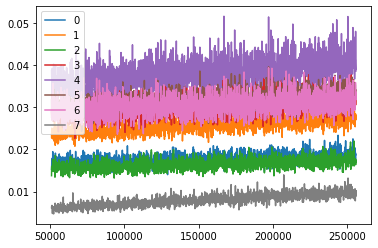

In [32]:
plt.plot(valid_steps[len(valid_steps)//5:], np.array(valid_sampled_ls)[len(valid_steps)//5:,:])
plt.legend(np.arange(0,8))

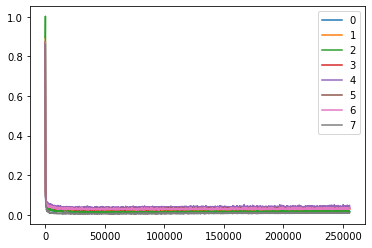

In [40]:
plt.plot(valid_steps, np.array(valid_sampled_ls))
plt.legend(np.arange(0,8))

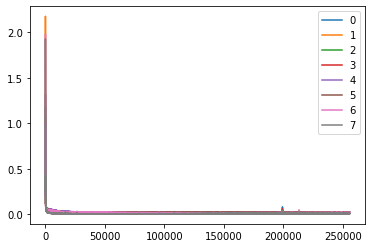

In [43]:
plt.plot(steps[:-1], np.array(sampled_ls)[:,:])
plt.legend(np.arange(0,8))

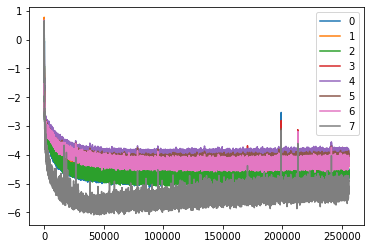

In [44]:
plt.plot(steps[:-1], np.log(np.array(sampled_ls)[:,:]))
plt.legend(np.arange(0,8))

In [31]:
np.arange(0,8)

array([0, 1, 2, 3, 4, 5, 6, 7])

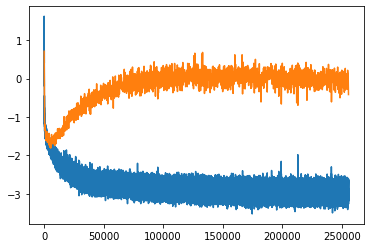

In [24]:
    
plt.plot(steps, losses)
plt.plot(valid_steps, valid_losses)

In [17]:
# Maybe load model 
valid_data_iter = iter(tf_valid_data.repeat(-1))
valid_obs, valid_acts, valid_goals, valid_mask,_,_ = valid_data_iter.next()
#valid_obs, valid_acts, valid_goals, valid_mask = sample_sequence_batch(valid_data)
valid_loss = step(valid_obs, valid_acts, valid_goals, model, valid_mask)
model.load_weights('saved_models/good1obj2048')
valid_loss = step(valid_obs, valid_acts, valid_goals, model, valid_mask)
print(valid_loss)

(<tf.Tensor: shape=(), dtype=float32, numpy=3.9090295>, <tf.Tensor: shape=(8,), dtype=float32, numpy=
array([0.01546957, 0.02166959, 0.01402429, 0.02576317, 0.0327089 ,
       0.02573003, 0.02735469, 0.00450491], dtype=float32)>)


In [ ]:
print(sum(data_time), sum(train_time)) #Tristan pls fix my retarded data input pipieline

In [ ]:
model.summary()

In [25]:
model.save_weights('good1obj2048')

In [ ]:
# for i in range(0, g.shape[-1]):
#     plt.hist( g[:, :, i])
#     plt.show()

# Perfect, Deterministic Reset and Replay

In [18]:
import gym
import time
import pandaRL
if RELATIVE_JOINTS:
    env = gym.make('pandaPlayJoints1Obj-v0')
    #env = gym.make('pandaPlayJoints-v0')
else:
    env = gym.make('pandaPlay-v0')
env.render('human')
env.reset()

current_dir=/home/sholto/Desktop/AI/pandaRL/pandaRL/envs


/home/sholto/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


/home/sholto/Desktop/AI/pandaRL/pandaRL/envs


{'observation': array([-6.6357821e-02,  2.3580584e-01,  7.9420589e-02, -4.9999976e-01,
         4.9999255e-01,  5.0000739e-01,  5.0000030e-01,  0.0000000e+00,
        -1.2918808e-01,  2.8176775e-02, -2.7010278e-04,  4.0200380e-14,
        -7.2021755e-15,  1.7250815e-14,  1.0000000e+00,  8.0247079e-35,
         0.0000000e+00,  4.3836804e-03,  0.0000000e+00], dtype=float32),
 'achieved_goal': array([-1.2918808e-01,  2.8176775e-02, -2.7010278e-04,  4.0200380e-14,
        -7.2021755e-15,  1.7250815e-14,  1.0000000e+00,  8.0247079e-35,
         0.0000000e+00,  4.3836804e-03,  0.0000000e+00], dtype=float32),
 'desired_goal': array([-0.15364923,  0.07796738,  0.08020185], dtype=float32),
 'controllable_achieved_goal': array([-0.06635782,  0.23580584,  0.07942059,  0.        ], dtype=float32),
 'full_positional_state': array([-6.6357821e-02,  2.3580584e-01,  7.9420589e-02, -4.9999976e-01,
         4.9999255e-01,  5.0000739e-01,  5.0000030e-01,  0.0000000e+00,
        -1.2918808e-01,  2.8176775

In [103]:
# Ok so the loop is

# Get the test and goal
# reset to the test state 
# get ag
# 

import tests
from importlib import reload
reload(tests)

for test in tests.test_list:
    # get the goal and reset to the init position
    print(f"\n Test: {test.__name__}")
    
    goal = tf.expand_dims(test(env),0)
    state = env.panda.calc_state()
    o = tf.expand_dims(state['observation'],0)
    initial_ag = state['achieved_goal']

    retries = 1
    for i in range(0,retries):
        past_state = [None, None]
        for i in range(0, rsd.MAX_SEQ_LEN):
            # Update this to the colab style model (I was just using the old one I trained)
            distrib, past_state = model(o, goal,  past_state = past_state)
            a = distrib.sample().numpy().squeeze() 
            o, r, d, _ = env.step(a)
            o = tf.expand_dims(o['observation'], 0)
            
    state = env.panda.calc_state()
    final_ag = state['achieved_goal']
    
    tests.measure_progress(initial_ag, final_ag, np.squeeze(goal.numpy()))
            
    


 Test: door_left
0/1 [==============>...............] - ETA: 0s - L1: 0.0132
 Test: door_right
0/1 [=================>............] - ETA: 0s - L1: 0.0103
 Test: open_drawer
0/1 [..............................] - ETA: 0s - L1: 0.0183
 Test: close_drawer
0/1 [=====================>........] - ETA: 0s - L1: 0.0046
 Test: push_left
0/1 [......................................................] - ETA: 0s - L1: 0.0328
 Test: push_right
0/1 [................................................] - ETA: 0s - L1: 0.0292
 Test: block_in_cupboard_right
0/1 [..............................] - ETA: 0s - L1: 0.0413
 Test: block_in_cupboard_left
0/1 [..............................] - ETA: 0s - L1: 0.0410
 Test: block_in_cupboard_right_upright
0/1 [..............................] - ETA: 0s - L1: 0.0423
 Test: block_in_cupboard_left_upright
0/1 [..............................] - ETA: 0s - L1: 0.0426
 Test: block_default_to_upright
0/1 [................................] - ETA: 0s - L1: 0.1022
 Test: block_len

In [70]:
np.set_printoptions(precision=2, suppress=True)

In [94]:
state = env.panda.calc_state()
final_ag = state['achieved_goal']
end_goal = np.squeeze(goal.numpy())
print('i', initial_ag)
print('f', final_ag)
print('g', end_goal)
initial_distance = abs(end_goal - initial_ag)
print('fe',initial_distance)
final_distance = abs(end_goal - final_ag)
print('p', final_distance)
print(np.mean(initial_distance), np.mean(final_distance))
progress = 1- (np.mean(final_distance) / np.mean(initial_distance))
print(progress)
#dimensional_progress = (progress)/(full_extent+1e-10)
# print('d', dimensional_progress)
# mean_progress = np.mean(progress)/np.mean(full_extent)
#print(mean_progress)

i [0.   0.2  0.   0.   0.   0.   1.   0.15 0.   0.03 0.  ]
f [ 0.    0.2  -0.   -0.   -0.    0.    1.    0.15 -0.15  0.03  0.  ]
g [ 0.    0.2   0.    0.    0.    0.    1.   -0.15  0.    0.03  0.  ]
fe [0.  0.  0.  0.  0.  0.  0.  0.3 0.  0.  0. ]
p [0.   0.   0.   0.   0.   0.   0.   0.3  0.15 0.   0.  ]


In [96]:
print(np.mean(initial_distance), np.mean(final_distance))
progress = 1- (np.mean(final_distance) / np.mean(initial_distance))
print(progress)

0.02727273 0.04100182
-0.5033999681472778


In [25]:
t_it = iter(tf_train_data)


In [26]:
o, a, g, m, pth, tsteps = t_it.next()
print(o.shape, a.shape, g.shape, m.shape)

(32, 80, 19) (32, 80, 8) (32, 80, 11) (32, 80)


In [13]:
idx = np.random.choice(len(o))
traj_end = len(np.where(m[idx] == 1)[0])-1
#env.panda.reset_goal_pos(ag_to_dg(g[idx, traj_end,:]))
env.p.restoreState(fileName=dataset_path+'states_and_ims/'+str(int(pth[idx]))+'/env_states/'+str(int(tsteps[idx,0]))+'.bullet')



In [28]:
for i in range(0, traj_end+1):
    #env.p.restoreState(fileName=dataset_path+str(int(pth[idx]))+'/env_states/'+str(int(tsteps[idx,i]))+'.bullet')
    #time.sleep(0.1)
    env.step(a[idx, i, :])

In [19]:
def test_subsequences(t_it, retries = 3, use_ori = True, replay=False):
    
    
    obs, acts, goals, masks, pth, tsteps = t_it.next()
    idx = np.random.choice(len(obs))
    
    
    start_idx = str(int(tsteps[idx,0]))
    traj_end = len(np.where(masks[idx] == 1)[0])-1
    
    env.p.restoreState(fileName=dataset_path+'states_and_ims/'+str(int(pth[idx]))+'/env_states/'+str(int(tsteps[idx,0]))+'.bullet')
    print(dataset_path+'states_and_ims/'+str(int(pth[idx]))+'/env_states/'+str(int(tsteps[idx,0]))+'.bullet')
    o = tf.expand_dims(obs[idx][0],0)
    
    goal = goals[idx, traj_end,:]
    #env.panda.reset_goal_pos(ag_to_dg(goal))
    goal = tf.expand_dims(goal, 0)
    
    
    if replay:
        retries = 1

        
    for i in range(0,retries):
        past_state = [None, None]
        for i in range(0, traj_end+1):

            
            if not use_ori:
                a[3:7] =  np.array(env.panda.default_arm_orn) # because it hasn't ever had to cope with
            if replay:
                a=acts[idx, i, :] # uncomment this to replay play subsequences
            else:
                distrib, past_state = model(o, goal,  past_state = past_state)
                a = distrib.sample().numpy().squeeze() 
                
            o, r, d, _ = env.step(a)
            o = tf.expand_dims(o['observation'], 0)

In [20]:

data = iter(tf_valid_data)
for i in range(0,100):
    test_subsequences(data, retries=2)

data_collection/collected_data/play_one_obj_demos/states_and_ims/2/env_states/798.bullet
data_collection/collected_data/play_one_obj_demos/states_and_ims/2/env_states/127.bullet
data_collection/collected_data/play_one_obj_demos/states_and_ims/2/env_states/2213.bullet
data_collection/collected_data/play_one_obj_demos/states_and_ims/14/env_states/830.bullet
data_collection/collected_data/play_one_obj_demos/states_and_ims/14/env_states/4132.bullet
data_collection/collected_data/play_one_obj_demos/states_and_ims/14/env_states/4905.bullet
data_collection/collected_data/play_one_obj_demos/states_and_ims/14/env_states/2693.bullet
data_collection/collected_data/play_one_obj_demos/states_and_ims/2/env_states/829.bullet
data_collection/collected_data/play_one_obj_demos/states_and_ims/14/env_states/2429.bullet
data_collection/collected_data/play_one_obj_demos/states_and_ims/14/env_states/1141.bullet
data_collection/collected_data/play_one_obj_demos/states_and_ims/2/env_states/835.bullet


KeyboardInterrupt: 

# MLP Evaluation

In [246]:
loc = [0,1]
scale = [10,3]
dist = tfd.TransformedDistribution(
                                    distribution= tfd.QuantizedDistribution(
                                            distribution=tfd.TransformedDistribution(
                                                distribution=tfd.Logistic(loc=loc, scale=scale),
                                            bijector=tfb.AffineScalar(shift=-0.5)),
                                        low=-128,
                                        high=128), 
                                    bijector=tfb.AffineScalar(scale=1/512))


mixture = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(
                          probs=[1,1]),components_distribution=dist)

values = []
for i in range(0,100):
    values.append(dist.sample().numpy()[0])
print(values)
plt.hist(values, bins=50)

In [ ]:
def ag_to_dg(ag):
    dg = np.concatenate([ag[0:3], ag[7:10]])
    return dg

In [36]:
import gym
import time
import pandaRL
env = gym.make('pandaPlayJoints1Obj-v0')
env.reset()
env.render('playback')

current_dir=/home/sholto/Desktop/AI/pandaRL/pandaRL/envs
/home/sholto/Desktop/AI/pandaRL/pandaRL/envs


/home/sholto/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [ ]:
# This below is only appropriate for non sequence models, which will aim for shorter timespans. 
n_valid_trajectories = len(valid_data['obs'])
idx = np.random.choice(n_valid_trajectories)
traj_obs, traj_acts, traj_init_o, traj_init_v = [valid_data[key][idx] for key in valid_data.keys()]

In [ ]:

o = env.reset()
# A few representative points along the trajectory for us to test how it goes from there (before it loses coherence
# over the long trajectory)
ZERO, QUARTER, HALF, THREEQ = 0, len(traj_obs)//4, len(traj_obs)//2, len(traj_obs)*3//4
# Get the init point
init_o = traj_obs[THREEQ][START_OBS:END_OBS]# traj_init_o
# reset to our desired init, but with 0 velocity - fine for now. 
env.robot.reset(env, init_o, traj_init_v)
# select the goal as the end state of the trajectory 
goal = traj_obs[-1][START_GOAL:END_GOAL]
for i in range(len(traj_acts)):
    o = tf.expand_dims(np.concatenate([o[START_OBS:END_OBS], goal], -1),0)
    if PROBS:# need to sample from the model if its probabilistic. 
        a = model(o).sample()[0]
    else:
        a = model.predict(o)[0]
    #a = traj_acts[i]
    o, r, d, _ = env.step(a) # the key change
    
    env.render()

# LSTM Evaluation

In [ ]:
valid = dataset[int(N_TRAJS*train_partition):]

def test_subsequences():
    
    obs, acts, goals, masks = sample_sequence_batch(valid)
    o = env.reset()
    idx = np.random.choice(len(obs))
    traj_end = len(np.where(masks[idx] == 1)[0])-1

    masks[idx][traj_end]
    start_pos = obs[idx][0][START_OBS:END_OBS].numpy()
    goal = np.expand_dims(obs[idx][traj_end][START_GOAL:END_GOAL],0)
    zero_vel = np.zeros(29)

    env.robot.reset(env, start_pos, zero_vel)
    o = np.squeeze(obs[idx][0])
    env.render()
    past_state = [None, None]
    
    for i in range(0,3):
        for i in range(0, traj_end+1):
            o = tf.expand_dims(o[START_OBS:END_OBS], 0)
            distrib, past_state = model(o, goal,  past_state = past_state)

            a = distrib.sample().numpy().squeeze() 
            #a = acts[idx, i, :] # uncomment this to replay play subsequences
            o, r, d, _ = env.step(a)
            env.render()


In [ ]:
for i in range(0,100):
    test_subsequences()

In [ ]:
# What about on a full trajectory? Where we give it the intermediate goals?
n_valid_trajectories = len(valid)
idx = np.random.choice(n_valid_trajectories)
traj_obs, traj_acts, traj_goals, traj_init_o, traj_init_v = [valid[idx][key] for key in valid[idx].keys()]
o = env.reset()
traj_len = len(traj_obs)
intervals = np.array([0, traj_len//4, traj_len//2, traj_len*3//4, traj_len])
init_o = traj_obs[0][START_OBS:END_OBS]# traj_init_o
# reset to our desired init, but with 0 velocity - fine for now. 
env.robot.reset(env, init_o, traj_init_v)
env.render()

    


In [ ]:
past_state = [None, None]
for t in range(traj_len):
        goal_idx = np.where(t < intervals)[0][0] # which part of the task we are up to
        goal = tf.cast(tf.expand_dims(traj_obs[intervals[goal_idx]-1][START_GOAL:END_GOAL], 0), tf.float32)
        o = tf.cast(tf.expand_dims(o[START_OBS:END_OBS],0), tf.float32)
        distrib, past_state = model(o,goal, past_state = past_state)
        
        #a = distrib.sample().numpy().squeeze() 
        a = traj_acts[t, :] # uncomment this to replay play subsequences
        o, r, d, _ = env.step(a)
        env.render()

In [ ]:
mine = [2,3,2,1,0,1,0,3,3,1,1,3]
fast = [0,2,2,0,1,4,0,2,1,4,3,0]
print(np.mean(mine), np.mean(fast))

In [ ]:
tf.concat([o, goal], -1)

In [ ]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
#     train_acc_metric.update_state(y, logits)
    return loss_value

@tf.function
def test_step(x, y):
    val_logits = model(x, training=False)
#     val_acc_metric.update_state(y, val_logits)

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch}")
    start_time = time.time()
    progbar = Progbar(len(observations), verbose=1, interval=0.5)

    # Iterate over the batches of the dataset.
    for step, (obs,acts) in enumerate(zip(observations, actions)):
#         obs = traj_batch['observations']
#         acts = traj_batch['actions']
    
        loss_value = train_step(obs, acts)
        progbar.add(1, [('Loss', loss_value)])
#     print()
        
    # Display metrics at the end of each epoch.
#     train_acc = train_acc_metric.result()
#     print("Training acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
#     train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
#     for x_batch_val, y_batch_val in val_dataset:
#         test_step(x_batch_val, y_batch_val)

#     val_acc = val_acc_metric.result()
#     val_acc_metric.reset_states()
#     print("Validation acc: %.4f" % (float(val_acc),))    

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch}")
    start_time = time.time()
    progbar = Progbar(len(observations), verbose=1, interval=0.5)

    # Iterate over the batches of the dataset.
    for step, (obs,acts) in enumerate(zip(observations, actions)):
#         obs = traj_batch['observations']
#         acts = traj_batch['actions']
    
        loss_value = train_step(obs, acts)
        progbar.add(1, [('Loss', loss_value)])
#     print()
        
    # Display metrics at the end of each epoch.
#     train_acc = train_acc_metric.result()
#     print("Training acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
#     train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
#     for x_batch_val, y_batch_val in val_dataset:
#         test_step(x_batch_val, y_batch_val)

#     val_acc = val_acc_metric.result()
#     val_acc_metric.reset_states()
#     print("Validation acc: %.4f" % (float(val_acc),))    

In [ ]:
model.summary()

In [ ]:
import gym
import adept_envs

env = gym.make("kitchen_relax-v1")

# MLP Evaluation

In [ ]:
# This below is only appropriate for non sequence models, which will aim for shorter timespans. 
n_valid_trajectories = len(valid_data['obs'])
idx = np.random.choice(n_valid_trajectories)
traj_obs, traj_acts, traj_init_o, traj_init_v = [valid_data[key][idx] for key in valid_data.keys()]

In [ ]:

o = env.reset()
# A few representative points along the trajectory for us to test how it goes from there (before it loses coherence
# over the long trajectory)
ZERO, QUARTER, HALF, THREEQ = 0, len(traj_obs)//4, len(traj_obs)//2, len(traj_obs)*3//4
# Get the init point
init_o = traj_obs[THREEQ][START_OBS:END_OBS]# traj_init_o
# reset to our desired init, but with 0 velocity - fine for now. 
env.robot.reset(env, init_o, traj_init_v)
# select the goal as the end state of the trajectory 
goal = traj_obs[-1][START_GOAL:END_GOAL]
for i in range(len(traj_acts)):
    o = tf.expand_dims(np.concatenate([o[START_OBS:END_OBS], goal], -1),0)
    if PROBS:# need to sample from the model if its probabilistic. 
        a = model(o).sample()[0]
    else:
        a = model.predict(o)[0]
    #a = traj_acts[i]
    o, r, d, _ = env.step(a) # the key change
    
    env.render()

# LSTM Evaluation

In [ ]:

def test_subsequences():
    obs, acts, masks = sample_sequence_batch(valid_data)
    o = env.reset()
    idx = np.random.choice(len(obs))
    traj_end = len(np.where(masks[idx] == 1)[0])-1

    masks[idx][traj_end]
    start_pos = obs[idx][0][START_OBS:END_OBS].numpy()
    goal = obs[idx][traj_end][START_GOAL:END_GOAL]
    zero_vel = np.zeros(29)

    env.robot.reset(env, start_pos, zero_vel)
    o = np.squeeze(obs[idx][0])
    env.render()


    past_state = [None, None]

    for i in range(0, traj_end+1):
        o = tf.expand_dims(np.concatenate([o[START_OBS:END_OBS], goal], -1),0)
        distrib, past_state = model(o, past_state = past_state)
        #a = acts[idx, i, :] # uncomment this to replay play subsequences
        a = distrib.sample().numpy().squeeze() 
        o, r, d, _ = env.step(a)
        env.render()
    

In [ ]:
for i in range(0,100):
    test_subsequences()

In [ ]:
valid_data

In [ ]:
# What about on a full trajectory? Where we give it the intermediate goals?
n_valid_trajectories = len(valid_data)
idx = np.random.choice(n_valid_trajectories)
traj_obs, traj_acts, traj_init_o, traj_init_v = [valid_data[key][idx] for key in valid_data.keys()]
o = env.reset()
traj_len = len(traj_obs)
intervals = np.array([0, traj_len//4, traj_len//2, traj_len*3//4, traj_len])
init_o = traj_obs[0][START_OBS:END_OBS]# traj_init_o
# reset to our desired init, but with 0 velocity - fine for now. 
env.robot.reset(env, init_o, traj_init_v)
env.render()

    


In [ ]:
past_state = [None, None]
for t in range(traj_len):
        goal_idx = np.where(t < intervals)[0][0] # which part of the task we are up to
        goal = traj_obs[intervals[goal_idx]-1][START_GOAL:END_GOAL]
        o = tf.expand_dims(np.concatenate([o[START_OBS:END_OBS], goal], -1),0)
        distrib, past_state = model(o, past_state = past_state)
        #a = acts[idx, i, :] # uncomment this to replay play subsequences
        a = distrib.sample().numpy().squeeze() 
        o, r, d, _ = env.step(a)
        env.render()

In [ ]:
# What about on a full trajectory? Where we give it the intermediate goals?
n_valid_trajectories = len(valid_data)
idx = np.random.choice(n_valid_trajectories)
traj_obs, traj_acts, traj_init_o, traj_init_v = [valid_data[key][idx] for key in valid_data.keys()]
o = env.reset()
traj_len = len(traj_obs)
intervals = np.array([0, traj_len//4, traj_len//2, traj_len*3//4, traj_len])
init_o = traj_obs[0][START_OBS:END_OBS]# traj_init_o
# reset to our desired init, but with 0 velocity - fine for now. 
env.robot.reset(env, init_o, traj_init_v)
env.render()

    


In [ ]:
past_state = [None, None]
for t in range(traj_len):
        goal_idx = np.where(t < intervals)[0][0] # which part of the task we are up to
        goal = traj_obs[intervals[goal_idx]-1][START_GOAL:END_GOAL]
        o = tf.expand_dims(np.concatenate([o[START_OBS:END_OBS], goal], -1),0)
        distrib, past_state = model(o, past_state = past_state)
        #a = acts[idx, i, :] # uncomment this to replay play subsequences
        a = distrib.sample().numpy().squeeze() 
        o, r, d, _ = env.step(a)
        env.render()

In [ ]:
goal

In [ ]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
#     train_acc_metric.update_state(y, logits)
    return loss_value

@tf.function
def test_step(x, y):
    val_logits = model(x, training=False)
#     val_acc_metric.update_state(y, val_logits)

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch}")
    start_time = time.time()
    progbar = Progbar(len(observations), verbose=1, interval=0.5)

    # Iterate over the batches of the dataset.
    for step, (obs,acts) in enumerate(zip(observations, actions)):
#         obs = traj_batch['observations']
#         acts = traj_batch['actions']
    
        loss_value = train_step(obs, acts)
        progbar.add(1, [('Loss', loss_value)])
#     print()
        
    # Display metrics at the end of each epoch.
#     train_acc = train_acc_metric.result()
#     print("Training acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
#     train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
#     for x_batch_val, y_batch_val in val_dataset:
#         test_step(x_batch_val, y_batch_val)

#     val_acc = val_acc_metric.result()
#     val_acc_metric.reset_states()
#     print("Validation acc: %.4f" % (float(val_acc),))    

In [23]:
0.3*180

54.0

In [24]:
54/9

6.0

In [27]:
48+6+45

99

In [28]:
45/8

5.625

In [29]:
48**(1/2)

6.928203230275509

In [30]:
135/5

27.0

In [31]:
705-25*27

30

In [32]:
570-20*27

30